In [17]:
from itertools import product
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# read input file
filepath = "space_mountain_with_holiday_weather_lag_new.csv"
df = pd.read_csv(filepath)


In [19]:
# one hot encode the Day of Week column
df = pd.get_dummies(df, columns=['Day of Week']) 


In [20]:
# ------ SPLITTING DATASET ------
train_years = ['14', '15', '16', '17', '18', '19', '22']
dev_years = ['23']
test_years = ['24', '25']

df['Year'] = df['Date'].apply(lambda x: x.split('/')[-1])  # Extract year as a string
df = df[df['Time of Day'] >= 450]
df['Time_sq'] = df['Time of Day'] ** 2
df['Time_sin'] = np.sin(2 * np.pi * df['Time of Day'] / 1440)
df['Time_cos'] = np.cos(2 * np.pi * df['Time of Day'] / 1440)

train_df = df[df['Year'].isin(train_years)]
dev_df = df[df['Year'].isin(dev_years)]
test_df = df[df['Year'].isin(test_years)]

print("Train size:", train_df.shape)
print("Dev size:", dev_df.shape)
print("Test size:", test_df.shape)

Train size: (30844, 26)
Dev size: (5056, 26)
Test size: (7142, 26)


In [21]:
# getting datasets
def get_X_y(dataframe):
    y = dataframe['Wait Time'].values
    X = dataframe.drop(columns=['Wait Time', 'Date', 'Time', 'Year'])
    return X, y

X_train, y_train = get_X_y(train_df)
X_dev, y_dev = get_X_y(dev_df)
X_test, y_test = get_X_y(test_df)


In [22]:
# Grid of hyperparameters to try
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create all combinations of hyperparameters
param_combinations = list(product(param_grid['n_estimators'],
                                  param_grid['max_depth'],
                                  param_grid['learning_rate']))

best_params = None
best_rmse = float('inf')

print("Searching hyperparameters...\n")

for n_estimators, max_depth, learning_rate in param_combinations:
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train)
    y_dev_pred = model.predict(X_dev)
    rmse = np.sqrt(mean_squared_error(y_dev, y_dev_pred))
    print(f"n_estimators={n_estimators}, max_depth={max_depth}, lr={learning_rate:.2f} → Dev RMSE: {rmse:.2f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate
        }

# Retrain best model on train+dev
print("\nBest hyperparameters found:")
print(best_params)


Searching hyperparameters...

n_estimators=100, max_depth=3, lr=0.01 → Dev RMSE: 16.87
n_estimators=100, max_depth=3, lr=0.10 → Dev RMSE: 15.44
n_estimators=100, max_depth=3, lr=0.20 → Dev RMSE: 15.48
n_estimators=100, max_depth=5, lr=0.01 → Dev RMSE: 16.43
n_estimators=100, max_depth=5, lr=0.10 → Dev RMSE: 15.40
n_estimators=100, max_depth=5, lr=0.20 → Dev RMSE: 15.47
n_estimators=100, max_depth=7, lr=0.01 → Dev RMSE: 16.27
n_estimators=100, max_depth=7, lr=0.10 → Dev RMSE: 15.50
n_estimators=100, max_depth=7, lr=0.20 → Dev RMSE: 15.58
n_estimators=200, max_depth=3, lr=0.01 → Dev RMSE: 15.87
n_estimators=200, max_depth=3, lr=0.10 → Dev RMSE: 15.41
n_estimators=200, max_depth=3, lr=0.20 → Dev RMSE: 15.43
n_estimators=200, max_depth=5, lr=0.01 → Dev RMSE: 15.61
n_estimators=200, max_depth=5, lr=0.10 → Dev RMSE: 15.40
n_estimators=200, max_depth=5, lr=0.20 → Dev RMSE: 15.56
n_estimators=200, max_depth=7, lr=0.01 → Dev RMSE: 15.54
n_estimators=200, max_depth=7, lr=0.10 → Dev RMSE: 15.59
n

In [23]:
X_train_dev = pd.concat([X_train, X_dev])
y_train_dev = np.concatenate([y_train, y_dev])

best_model = XGBRegressor(
    **best_params,
    random_state=42,
    verbosity=0
)
best_model.fit(X_train_dev, y_train_dev)

# Test evaluation
y_test_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nTest RMSE with best model: {rmse_test:.2f}")


Test RMSE with best model: 14.62


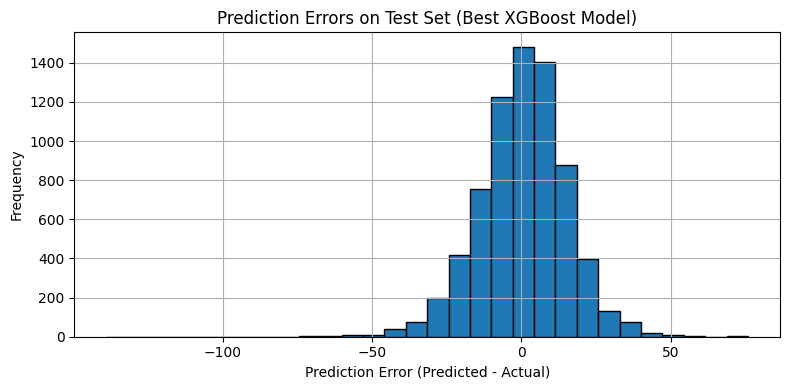

In [24]:
# Plot test error distribution
errors = y_test_pred - y_test
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Prediction Errors on Test Set (Best XGBoost Model)")
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()